Fazendo baselines zero-shot/few-shot com o BERTimbau para ver se o GANBERT tem o efeito desejado

In [1]:
#pra conseguir algum erro util da porra do torch
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import pipeline, AutoTokenizer, BertForSequenceClassification, get_constant_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, average_precision_score,f1_score
from tqdm import tqdm
import random
import torch
import time
import datetime
from skmultilearn.skmultilearn.model_selection.iterative_stratification import iterative_train_test_split
from sklearn.utils.class_weight import compute_class_weight


tqdm.pandas()

In [3]:
seed_val = 2023
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)
  device = 0

In [4]:
class EarlyStopper:
    def __init__(self, patience=4, min_delta=0,is_loss=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.is_loss = is_loss
        if is_loss:
            self.min_validation_loss = np.inf
        else:
            self.min_validation_loss = -np.inf

    def early_stop(self, validation_loss):
        if self.is_loss:
            if validation_loss < self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
                print("NEW LOWEST LOSS ",self.min_validation_loss)
            elif validation_loss >= (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False
        
        else:
            if validation_loss > self.min_validation_loss:
                self.min_validation_loss = validation_loss
                self.counter = 0
                print("NEW HIGHEST SCORE ",self.min_validation_loss)
            elif validation_loss <= (self.min_validation_loss + self.min_delta):
                self.counter += 1
                if self.counter >= self.patience:
                    return True
            return False

In [5]:
stop = EarlyStopper(is_loss=True)

In [6]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [7]:
device = 0 if torch.cuda.is_available() else -1
remove_neutral_instances= False


# Dados

In [8]:
def process_data(df,remove_neutral_instances=False):
    df['Alteração na eficiência/funcionalidade'] = (df['Alteração na eficiência/funcionalidade'] == 1) | (df["Alteração da funcionalidade"] == 1) | (df["Alteração na eficiência"] == 1)
    df = df.drop(["Postagem com possível perfil depressivo","Alteração na eficiência",
         "Alteração da funcionalidade","*",'Agitação/inquietação','Sintoma obsessivo e compulsivo','Déficit de atenção/Memória',
              'Perda/Diminuição do prazer/ Perda/Diminuição da libido'],axis=1)
    df['Neutro'] =  df.iloc[:,1:].sum(axis=1) == 0
    df = df.replace({True:1,False:0})
    if remove_neutral_instances == True:
        df = df.reset_index(drop=True)
        df = df[df.iloc[:,1:].sum(axis=1) != 0]
    df = df.reset_index(drop=True)
    return df

In [9]:
#df = pd.read_csv("data/segredos_sentenças_multitask_clean.csv",index_col=0)
#df['Alteração na eficiência/funcionalidade'] = (df['Alteração na eficiência/funcionalidade'] == 1) | (df["Alteração da funcionalidade"] == 1) | (df["Alteração na eficiência"] == 1)

In [10]:
#df = df.drop(["Postagem com possível perfil depressivo","Alteração na eficiência",
#         "Alteração da funcionalidade","*",'Agitação/inquietação','Sintoma obsessivo e compulsivo','Déficit de atenção/Memória',
#              'Perda/Diminuição do prazer/ Perda/Diminuição da libido'],axis=1)

In [11]:
train_df = process_data(pd.read_csv("data/segredos_sentenças_multitask_train_clean.csv",index_col=0))
test_df = process_data(pd.read_csv("data/segredos_sentenças_multitask_test_clean.csv",index_col=0))


In [12]:
#symptom_num = df.iloc[:,1:].shape[1]
#target_names = list(df.iloc[:,1:].columns)

symptom_num = train_df.iloc[:,1:].shape[1]
target_names = list(train_df.iloc[:,1:].columns)


In [13]:
#if remove_neutral_instances == True:
#    df = df.reset_index(drop=True)
#    df = df[df.iloc[:,1:].sum(axis=1) != 0]
    

In [14]:
#df = df.reset_index(drop=True)

In [15]:
#from skmultilearn.skmultilearn.model_selection.iterative_stratification import IterativeStratification
#strat = IterativeStratification(n_splits=2).split(df,df.iloc[:,1:])

In [16]:
#train_df,_,test_df, _ = iterative_train_test_split(df,df.iloc[:,1:],test_size=0.5)

In [17]:
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

#strat = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=seed_val).split(df,df.iloc[:,1:])

In [18]:
#for train_idx, test_idx in strat:

#    train_df = df.loc[train_idx]
#    test_df  = df.loc[test_idx]
#    break

In [19]:
#for train_index,test_index in iterator:
    #print(train_index)
    #print(test_index)
#    train_df = df.loc[train_index]
#    test_df = df.loc[test_index]

In [20]:
#label_to_idx = {sintoma:i for i,sintoma in enumerate(label_list)}
#idx_to_label = {i:sintoma for i,sintoma in enumerate(label_list)}

# Usando só as embeddings (congelando as outras camadas)

In [21]:
#dataloaders

max_length = 128

def get_dataloader(df,tokenizer,batch_size,do_shuffle):
    examples = []
    input_ids = []
    attention_masks = []
    for text in df.text:
        encoded = tokenizer.encode_plus(text,return_attention_mask=True,add_special_tokens=True,max_length = max_length,
    padding="max_length",truncation=True)
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(df.iloc[:,1:].to_numpy(),dtype=torch.float32)
    
    dataset = torch.utils.data.TensorDataset(input_ids,attention_masks,labels)
    
    if do_shuffle:
        sampler = torch.utils.data.RandomSampler
    else:
        sampler = torch.utils.data.SequentialSampler
    return torch.utils.data.DataLoader(dataset,sampler = sampler(dataset),batch_size=batch_size)
    
       

## Usando só a "cabeça" do BertForSequenceClassification

O modelo já vem com uma "cabeça": uma camada Linear ao fim do modelo, com n_out igual ao n° de classes

In [22]:
model_path = "neuralmind/bert-base-portuguese-cased"

In [23]:
learning_rate = 5e-5
num_train_epochs =20
print_each_n_step = 10
seed = 42
batch_size= 32




In [24]:
seed_val = 2023
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)
  device = 0

In [25]:
model = BertForSequenceClassification.from_pretrained(model_path,num_labels=symptom_num)
tokenizer = AutoTokenizer.from_pretrained(model_path)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the

In [26]:
train_dataloader = get_dataloader(train_df,tokenizer,batch_size,do_shuffle=True)
test_dataloader = get_dataloader(test_df,tokenizer,batch_size,do_shuffle=False)

## Finetuning de tudo???

In [27]:
learning_rate = 5e-5
num_train_epochs = 20
print_each_n_step = 10
batch_size= 32
warmup_proportion = 0.15
apply_scheduler = True

In [28]:
class BERTMixup(torch.nn.Module):
    def __init__(self,model,frozen_layers=0,mixup_layer=12,mixup_alpha=1,dropout_rate=0.1):
        super(BERTMixup,self).__init__()
        self.model = model
        for i, layer in enumerate(self.model.bert.encoder.layer):
            if i < frozen_layers:
                for param in layer.parameters():
                    param.requires_grad=False
        self.mixup_layer = mixup_layer
        self.mixup_alpha = mixup_alpha
        self.model.dropout.p = dropout_rate
    
    def forward(self,input_ids,attention_mask,labels):
        extended_attention_mask: extended_attention_mask = attention_mask[:, None,None,:]
        extended_attention_mask = extended_attention_mask.to(dtype=torch.float)
        extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(torch.float).min
        
        outputs = self.model.bert.embeddings(input_ids)
        
        for i, layer in enumerate(self.model.bert.encoder.layer):
            outputs = layer(outputs,attention_mask=extended_attention_mask)[0]
            if self.training:
                if i == (self.mixup_layer-1):
                    outputs, labels_a, labels_b, lamb = mixup(outputs,labels,self.mixup_alpha)
        outputs = self.model.bert.pooler(outputs)
        outputs = self.model.dropout(outputs)
        outputs = self.model.classifier(outputs)
                
        if self.training:
            return outputs,labels_a,labels_b,lamb
        else:
            return outputs


In [29]:
def mixup_criterion(criterion_params_a,criterion_params_b,lamb,criterion):
    return criterion(*criterion_params_a) * lamb + criterion(*criterion_params_b) * (1-lamb)

In [30]:
model = BERTMixup(model)
model = model.to(device)

In [31]:
#para referência https://link.springer.com/chapter/10.1007/978-3-642-38679-4_37
#e também https://www.kaggle.com/code/rejpalcz/best-loss-function-for-f1-score-metric

#por algum motivo foi pior do que otimizar por BCE...
#ainda é bom deixar guardado aqui, vai que é útil um dia!
def f1_differentiable_loss(sigmoid_vals,labels):
    #em caso de precisão ou recall igual a 0
    eps=1e-10
    #estamos tratando das probabilidades.
    #por exemplo, se labels é [0,1] e temos a prob [0.3,0.9]
    #temos um true positive rate de 0 + 0.9
    # um true negative rate de 0.7 + 0
    # um false positive rate de 0.3
    # e por fim um false negative rate de 0.1
    tp = torch.sum(labels*sigmoid_vals)
    tn = torch.sum((1-labels)*(1-sigmoid_vals))
    fp = torch.sum((1-labels)*sigmoid_vals)
    fn = torch.sum(labels * (1-sigmoid_vals))
    
    p = tp / (tp + fp + eps)
    r = tp / (tp + fn +eps)
    
    f1 = 2*p*r/ (p+r + eps)
    #queremos minimizar a perda de f1, portanto 1-f1
    return 1-f1.mean()

In [32]:
#fazendo minha própria focal loss porque a focal loss do kornia não funfa. 
#Por que o cara do pytorch mentiu pra mim ;_; ??

def focal_loss(inputs,target,alpha=1,gamma=2):
    #lembrando que a focal loss é só uma CE com "modulating factors"[
    base = torch.nn.BCELoss()(inputs,target)
    prob_diffs = (target - inputs).abs()
    loss = alpha *( (prob_diffs**gamma) * base )
    return loss.mean()
    
    
def focal_binary_cross_entropy(p, targets, gamma=4):
    #l = logits.reshape(-1)
    #t = targets.reshape(-1)
    #p = torch.sigmoid(l)
    p = torch.where(targets >= 0.5, p, 1-p)
    logp = - torch.log(torch.clamp(p, 1e-4, 1-1e-4))
    loss = logp*((1-p)**gamma)
    num_label = targets.shape[1]
    loss = num_label*loss.mean()
    return loss

In [33]:
#def new_and_improved(p,targets,gamma=3,alpha=0.8):
    #bce = torch.nn.functional.binary_cross_entropy(p,targets,reduction='none')
#    p = torch.where(targets == 1,p,1-p)
#    alpha = targets * alpha + (1-targets) * (1 - alpha)
#    return (alpha * (1 - p) ** gamma).mean()

In [34]:
def new_and_improved(p,targets,gamma=3,alpha=0.8):
    bce = torch.nn.functional.binary_cross_entropy(p,targets,reduction='none')
    p = torch.where(targets == 1,p,1-p)
    alpha = targets * alpha + (1-targets) * (1 - alpha)
    loss = (bce * alpha * (1 - p) ** gamma)
    return loss.mean()

In [35]:
def find_best_threshold(true_labels, probs):
    eps=1e-10
    thresholds = [i*0.1 for i in range(1,10)]
    max_score = 0
    for threshold in thresholds:
        cur_score = f1_score(true_labels,probs>threshold,average="macro")
        if cur_score > max_score:
            max_score = cur_score
            best_threshold = threshold
    return best_threshold


In [36]:
def mixup(batch_ids,batch_labels,alpha=1):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = batch_ids.size()[0]
 
    index = torch.randperm(batch_size).cuda()

    
    mixed_x = lam * batch_ids + (1 - lam) * batch_ids[index, :]
    #using bigger input mask
    #mixed_masks = batch_masks | batch_masks[index,:]
    y_a, y_b = batch_labels, batch_labels[index]
    return mixed_x, y_a, y_b, lam

In [37]:
#model.dropout.p = 0.5

In [38]:
def get_inverse_class_freqs(data):
    return 1 -torch.tensor(data.sum()/data.shape[0]).to(device)

In [39]:
training_stats = []

total_t0 = time.time()

model_vars = [i for i in model.parameters()]
optimizer =  torch.optim.AdamW(model_vars, lr= learning_rate)



if apply_scheduler:
    num_train_steps = int(len(train_dataloader) * num_train_epochs)
    num_warmup_steps = int(num_train_steps * warmup_proportion)

    scheduler = get_constant_schedule_with_warmup(optimizer, 
                                           num_warmup_steps = num_warmup_steps)


#lembrando que a função sigmoid é um "s" com o "meio" em x=0 y=0.5
threshold = 0.5 
#loss_func = torch.nn.BCELoss()
#loss_func = f1_differentiable_loss
#loss_func = focal_binary_cross_entropy
#loss_func = lambda x,y: new_and_improved(x,y,gamma=3,alpha=get_inverse_class_freqs(train_df.iloc[:,1:]))
loss_func = new_and_improved
train_loss_func = lambda x,y,z: mixup_criterion(x,y,z,criterion=new_and_improved)

sigmoid = torch.sigmoid
best_f1 = 0
best_epoch = 0
best_report = {}
best_auc = 0

best_loss = np.inf

for epoch_i in range(0,num_train_epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')
    t0 = time.time()
    
    tr_loss = 0
    
    model.train()
    all_probs = []
    all_labels_ids = []
    for step, batch in enumerate(train_dataloader):
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        cur_batch_size = b_input_ids.shape[0]
        
        
        output,labels_a,labels_b,lamb = model(b_input_ids,attention_mask = b_input_mask,labels=b_labels)
        #output,targets_a,targets_b,lam = mixup(output.logits,b_labels)

        
        all_probs += sigmoid(output).detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
        #loss = mixup_criterion(loss_func,sigmoid(output),targets_a,targets_b,lam)
        loss = train_loss_func((sigmoid(output),labels_a),(sigmoid(output),labels_a),lamb)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if apply_scheduler:
            scheduler.step()
        
        tr_loss += loss.item()
    
    all_probs = torch.stack(all_probs).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    
    threshold = find_best_threshold(all_labels_ids,all_probs)
    print("best threshold: ",threshold)
    
    avg_train_loss = tr_loss/len(train_dataloader)
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
    
    print("")
    print("Running Test...")
    
    model.eval()
    total_test_loss = 0
    all_probs = []
    all_labels_ids = []
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():
            outputs = model(b_input_ids,attention_mask = b_input_mask,labels=b_labels)
            total_test_loss += loss_func(sigmoid(outputs),b_labels)
            preds = sigmoid(outputs)
        all_probs += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()
    all_probs = torch.stack(all_probs).numpy()
    all_preds = all_probs > threshold
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    cur_report = classification_report(all_labels_ids,all_preds,target_names=target_names, zero_division=0,output_dict=True)
    
    cur_auc = average_precision_score(all_labels_ids,all_probs)
    
    if cur_auc > best_auc:
        #só pra ter certeza
        assert cur_auc != average_precision_score(all_labels_ids,all_probs,average='micro')
        best_auc = cur_auc
        best_auc_epoch = epoch_i
        #best_probs = all_probs
        #best_labels = all_labels_ids
        
        #model.save_pretrained("models/BERT baselines")

        
    if cur_report['macro avg']['f1-score'] >= best_f1:
        best_f1 = cur_report['macro avg']['f1-score']
        best_epoch = epoch_i
        best_report = cur_report

        
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    test_time = format_time(time.time() - t0)
    print("F1-score: ",cur_report['macro avg']['f1-score'])
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))
    
    if avg_test_loss < best_loss:
        best_probs = all_probs
        best_labels = all_labels_ids
        model.model.save_pretrained("models/BERT baselines")
    
    if stop.early_stop(avg_test_loss):
        break
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Test Loss': avg_test_loss,
            'F1-score':cur_report['macro avg']['f1-score'],
            'Training Time': training_time,
            'Test Time': test_time
        })


======== Epoch 1 / 20 ========
Training...
  Batch    10  of    122.    Elapsed: 0:00:05.
  Batch    20  of    122.    Elapsed: 0:00:09.
  Batch    30  of    122.    Elapsed: 0:00:13.
  Batch    40  of    122.    Elapsed: 0:00:18.
  Batch    50  of    122.    Elapsed: 0:00:22.
  Batch    60  of    122.    Elapsed: 0:00:26.
  Batch    70  of    122.    Elapsed: 0:00:31.
  Batch    80  of    122.    Elapsed: 0:00:35.
  Batch    90  of    122.    Elapsed: 0:00:39.
  Batch   100  of    122.    Elapsed: 0:00:44.
  Batch   110  of    122.    Elapsed: 0:00:48.
  Batch   120  of    122.    Elapsed: 0:00:52.
best threshold:  0.2

  Average training loss: 0.014
  Training epoch took: 0:00:53

Running Test...
F1-score:  0.09032771813679263
  Test Loss: 0.011
  Test took: 0:00:56
NEW LOWEST LOSS  0.010696673765778542

======== Epoch 2 / 20 ========
Training...
  Batch    10  of    122.    Elapsed: 0:00:04.
  Batch    20  of    122.    Elapsed: 0:00:09.
  Batch    30  of    122.    Elapsed: 0:00:1

In [40]:
best_fine_tuning_report = best_report
best_fine_tuning_epoch = best_epoch

In [41]:
print("BEST AUC: ",best_auc)
print("epoch", best_auc_epoch)

BEST AUC:  0.2835841113908538
epoch 2


In [42]:
best_probs.shape

(848, 19)

In [43]:
from sklearn.metrics import precision_recall_curve
preds = []
for i in range (best_probs.shape[1]):
    precision,recall,thresholds = precision_recall_curve(best_labels[:,i],best_probs[:,i])
    f1_scores = 2*recall*precision/(recall+precision)
    cur_threshold = thresholds[np.nanargmax(f1_scores)]
    print("melhor f1 para ",train_df.columns[i+1]," ",np.nanmax(f1_scores))
    preds.append(best_probs[:,i] >= cur_threshold)

melhor f1 para  Alteração de sono   0.06666666666666667
melhor f1 para  Alteração na eficiência/funcionalidade   0.10169491525423728
melhor f1 para  Tristeza/Humor depressivo   0.13053613053613053
melhor f1 para  Desamparo/Prejuízo social/Solidão   0.17659137577002051
melhor f1 para  Suicído/Auto-extermínio   0.0967741935483871
melhor f1 para  Preocupação/Medo /Ansiedade   0.06896551724137931
melhor f1 para  Desesperança   0.10256410256410256
melhor f1 para  Desvalia / Baixa autoestima   0.1149425287356322
melhor f1 para  Fator de risco   0.25310173697270477
melhor f1 para  Irritação / agressividade   0.10047095761381478
melhor f1 para  Sintoma físico   0.06557377049180328
melhor f1 para  Sentimento de culpa   0.10526315789473684
melhor f1 para  Morte / Suicído de outro   0.07407407407407407
melhor f1 para  Fator protetivo, cuidado em saúde e bem-estar   0.1553398058252427
melhor f1 para  Dificuldade para decidir   0.041666666666666664
melhor f1 para  Cansaço/Desânimo/Desencorajamento/

/tmp/ipykernel_9566/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_9566/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_9566/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_9566/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_9566/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_9566/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_9566/438058958.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2*recall*precision/(recall+precision)
/tmp/ipykernel_9566/

In [44]:
best_preds = np.array(preds).T
best_fine_tuning_report = classification_report(best_labels,best_preds,target_names=target_names, zero_division=0,output_dict=True)


<AxesSubplot:>

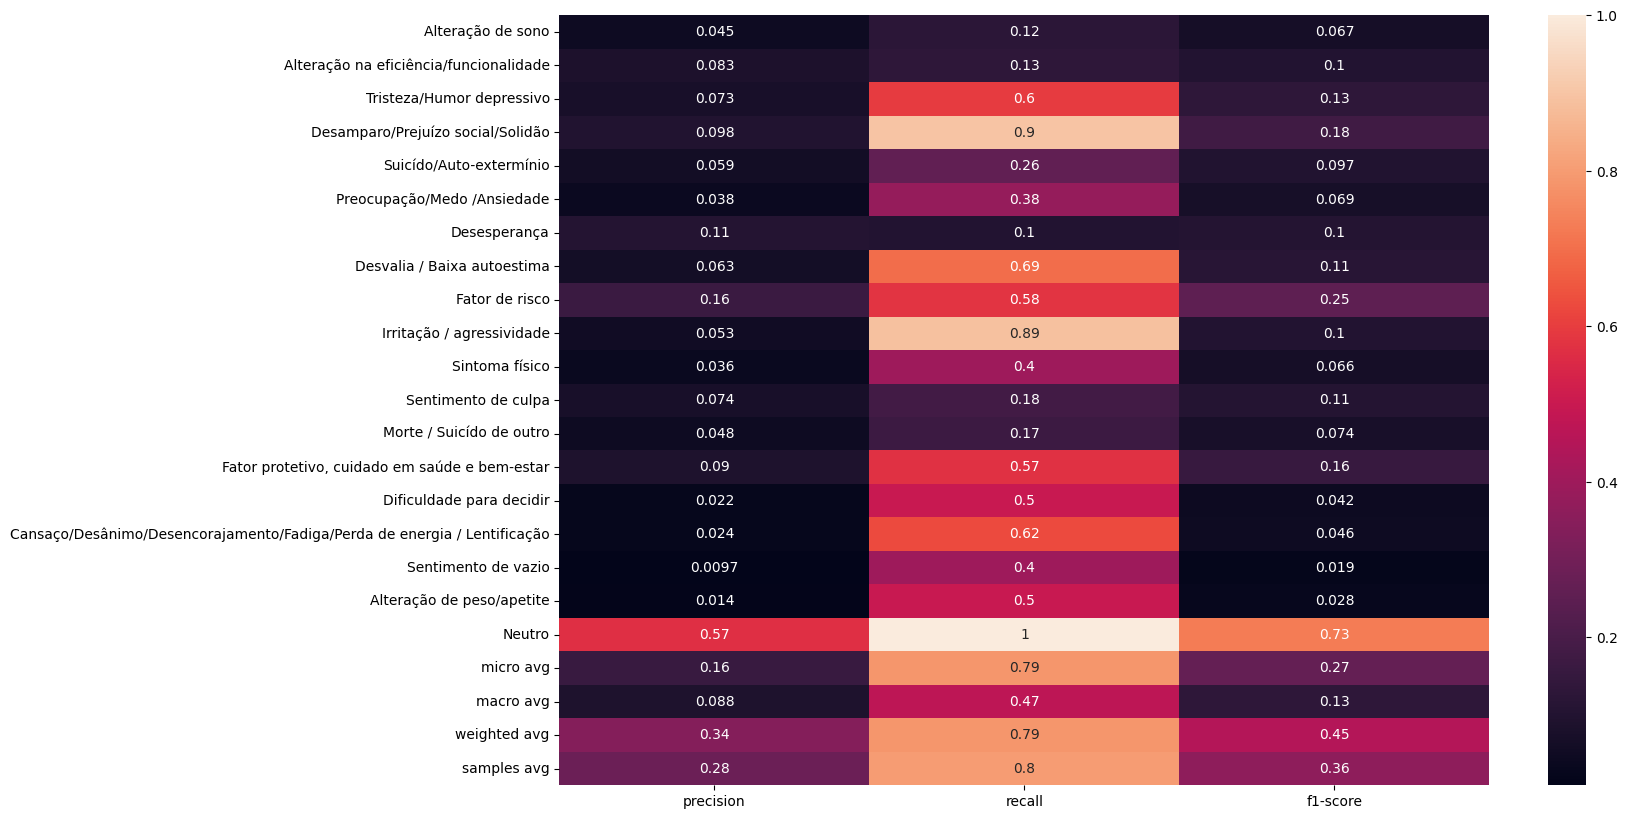

In [45]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(pd.DataFrame(best_fine_tuning_report).iloc[:-1, :].T, annot=True)

# Analisando os casos de erro

primeiro olhando o sintomas que o model erra mais. Lembre-se: o essencial é conhecer os dados!

In [46]:
for i,symptom in enumerate(target_names):
    new = []
    for j,text in enumerate(test_df.text):
        row = {"text":text,"predicted":preds[i][j],"label":best_labels[j][i]}
        new.append(row)
    new = pd.DataFrame(new)
    new.to_csv(f"error analysis/baselines/{symptom.replace('/',' ')}.csv")
        
        


# checando o cleanlab

In [47]:
lbs= []
for instance in best_labels:
    clss = []
    for i,cls in enumerate(instance):
        if cls == 1:
            clss.append(i)
    lbs.append(clss)

In [48]:
from cleanlab.count import estimate_joint

estimate_joint( labels=lbs,
            pred_probs=best_probs,
            confident_joint=None,
            multi_label=True).diagonal()

ModuleNotFoundError: No module named 'cleanlab'

In [ ]:
from cleanlab.filter import find_label_issues

find_label_issues(
    labels=lbs,
    pred_probs=best_probs,
    multi_label=True,
    return_indices_ranked_by="self_confidence",
)

In [ ]:
from cleanlab.dataset import health_summary
#isso não funfa por algum motivo... mandar issue no github depois
#health_summary(lbs,best_probs,class_names=target_names,multi_label=True)

In [ ]:
lbs

In [ ]:
from cleanlab.multilabel_classification import get_label_quality_scores
idx = (get_label_quality_scores(lbs, best_probs) < 0.25).nonzero()

In [ ]:
best_labels.sum(axis=0)

In [ ]:
best_labels[idx].sum(axis=0)

In [ ]:
#new = pd.read_csv("data/segredos_sentenças_multitask_test_clean.csv",index_col=0)
#new = new.drop(idx[0])
#new.to_csv("data/segredos_sentenças_multitask_test_clean_dropped.csv")

In [ ]:
#from cleanlab.dataset import find_overlapping_classes

#find_overlapping_classes(
#    labels=lbs,pred_probs=best_probs,
#    class_names=target_names,multi_label=True
#)